In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Input
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import random
import tensorflow as tf
from keras.optimizers import Adam


# random seed
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)
# set_seed(2024)

/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2024-07-20 19:16:21.159716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 19:16:21.160432: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could n

In [2]:
time_steps = 90
forecast_steps = 7

In [3]:
df = pd.read_csv('/root/autodl-tmp/7.18_SDGprediction/data/FB_SDG_3.csv')
data = df.iloc[:, 1].values

def create_dataset(data, time_steps=1, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data[i:(i + time_steps)])
        y.append(data[(i + time_steps):(i + time_steps + forecast_steps)])
    return np.array(X), np.array(y)

X, y = create_dataset(data, time_steps, forecast_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Linear regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lr_pred = lr_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)


# Lasso regression
print("Training Lasso Regression...")
lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
lasso_pred = lasso_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

print("Training KNN...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_pred = np.zeros_like(y_test)
for i in range(y_test.shape[0]):
    input_seq = X_test[i].reshape(1, -1)
    for j in range(forecast_steps):
        knn_model.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, j])
        pred = knn_model.predict(input_seq)
        knn_pred[i, j] = pred[0]  
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1] = pred[0]  


# Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor()
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
rf_pred = rf_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# XGBoost
print("Training XGBoost...")
xgb_model = XGBRegressor()
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(y_train.shape[0], -1))
xgb_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(y_test.shape)

# LSTM
print("Training LSTM...")
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
lstm_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer, loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
# lstm_model.fit(X_train_lstm, y_train, epochs=30, batch_size=32, verbose=1)
lstm_pred = lstm_model.predict(X_test_lstm).reshape(y_test.shape)


Training Linear Regression...
Training Lasso Regression...
Training KNN...
Training Random Forest...
Training XGBoost...
Training LSTM...
Epoch 1/50


2024-07-20 19:16:57.600690: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/autodl-tmp/miniconda3/envs/cytf/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 29.7230
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.9099
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 755737984.0000
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 350914560.0000
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.9289
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 543.2558
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.8902
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.8814
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 16821.0898
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.8907
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.8955
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.8949
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.8942
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.8934
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss:

In [4]:
print("Training GRU...")
X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
gru_model = Sequential()
gru_model.add(Input(shape=(time_steps, 1)))
gru_model.add(GRU(50, activation='relu', return_sequences=True))
gru_model.add(GRU(50, activation='relu'))
gru_model.add(Dense(forecast_steps))
optimizer = Adam(learning_rate=0.001)
gru_model.compile(optimizer=optimizer, loss='mse')
gru_model.fit(X_train_gru, y_train, epochs=50, batch_size=32, verbose=1)
gru_pred = gru_model.predict(X_test_gru).reshape(y_test.shape)

Training GRU...
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 2.7201
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.2050
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1806
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1745
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1727
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.1714
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1703
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1694
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1686
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1679
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.1672
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1667
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1663
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.1659
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - l

In [5]:
# model evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    return mse, mae

models = {'Linear Regression': lr_pred,  'Lasso Regression': lasso_pred, 'KNN': knn_pred, 'Random Forest': rf_pred, 'XGBoost': xgb_pred, 'LSTM': lstm_pred, 'GRU': gru_pred}
results = {}

for model_name, predictions in models.items():
    mse, mae = evaluate_model(y_test, predictions)
    results[model_name] = {'MSE': mse, 'MAE': mae}

# change to DataFrame
mse_df = pd.DataFrame({model: results[model]['MSE'] for model in results.keys()})
mae_df = pd.DataFrame({model: results[model]['MAE'] for model in results.keys()})

# calculate MSE and MAE
overall_mse = mse_df.mean()
overall_mae = mae_df.mean()

print("\nMSE for each time step:")
print(mse_df)
print("\nMAE for each time step:")
print(mae_df)

print("\nOverall MSE for each model:")
print(overall_mse)
print("\nOverall MAE for each model:")
print(overall_mae)



MSE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.094299          0.093752  0.242567       0.132240  0.188034   
1           0.137253          0.136124  0.401690       0.186187  0.245300   
2           0.146012          0.144791  0.405831       0.198306  0.262841   
3           0.151255          0.149932  0.359802       0.214131  0.226096   
4           0.154613          0.153318  0.355176       0.232953  0.232576   
5           0.156756          0.155704  0.374097       0.249906  0.269911   
6           0.160160          0.159006  0.375591       0.256007  0.270102   

       LSTM       GRU  
0  1.203189  0.135098  
1  1.047504  0.184817  
2  1.139998  0.200426  
3  1.199040  0.222593  
4  1.177203  0.198359  
5  1.142013  0.233883  
6  1.352803  0.211665  

MAE for each time step:
   Linear Regression  Lasso Regression       KNN  Random Forest   XGBoost  \
0           0.223614          0.223041  0.383330       0.275739 

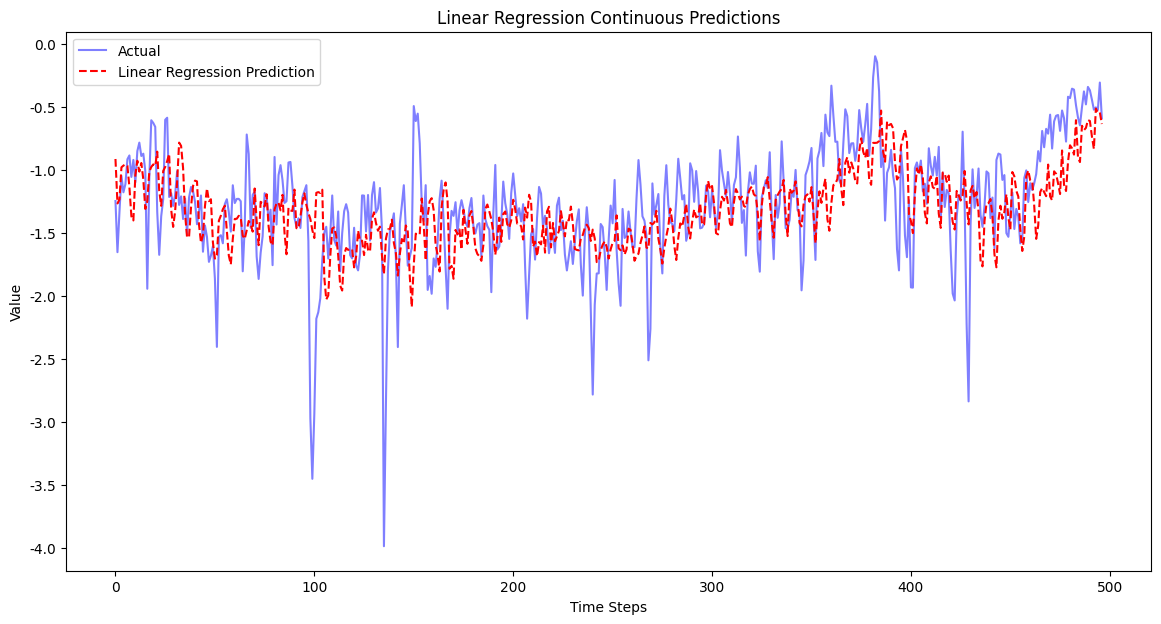

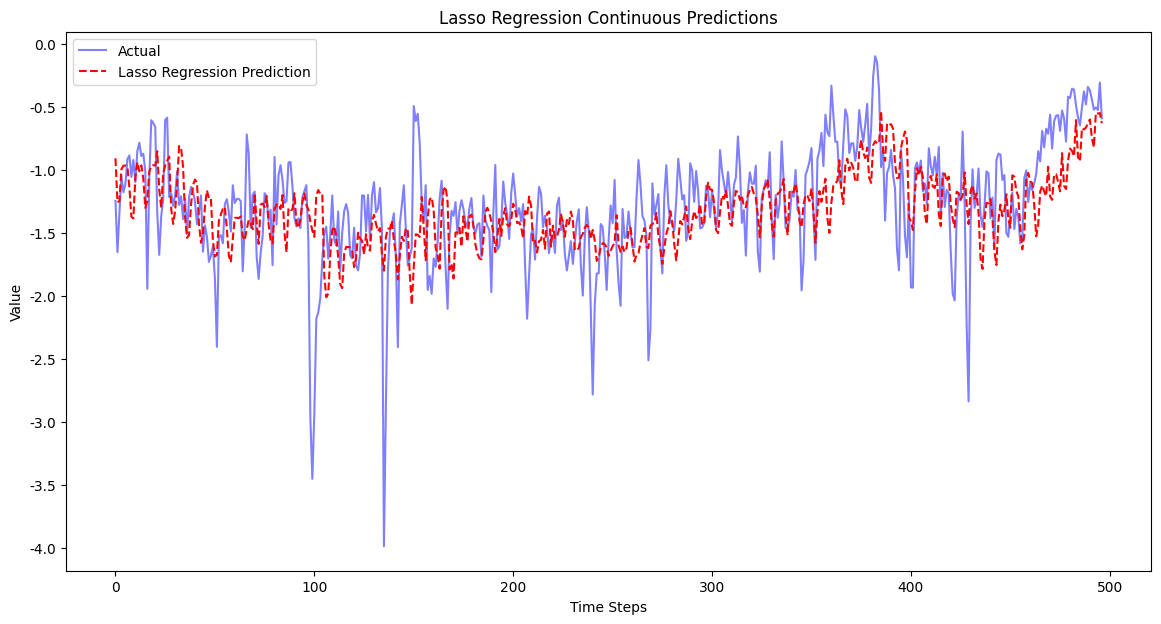

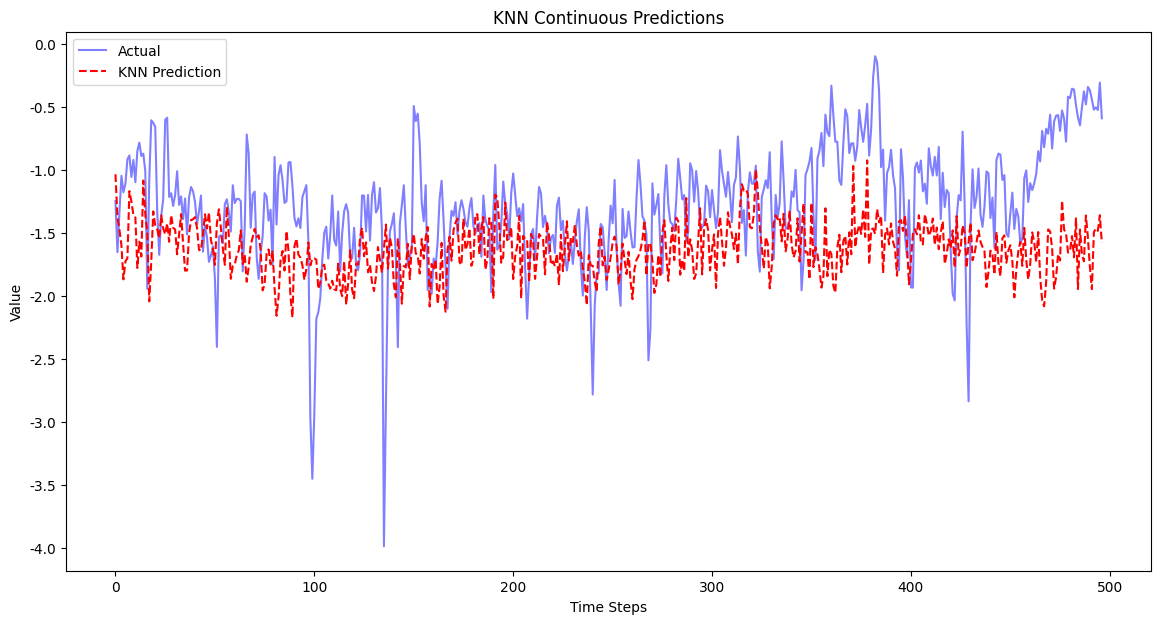

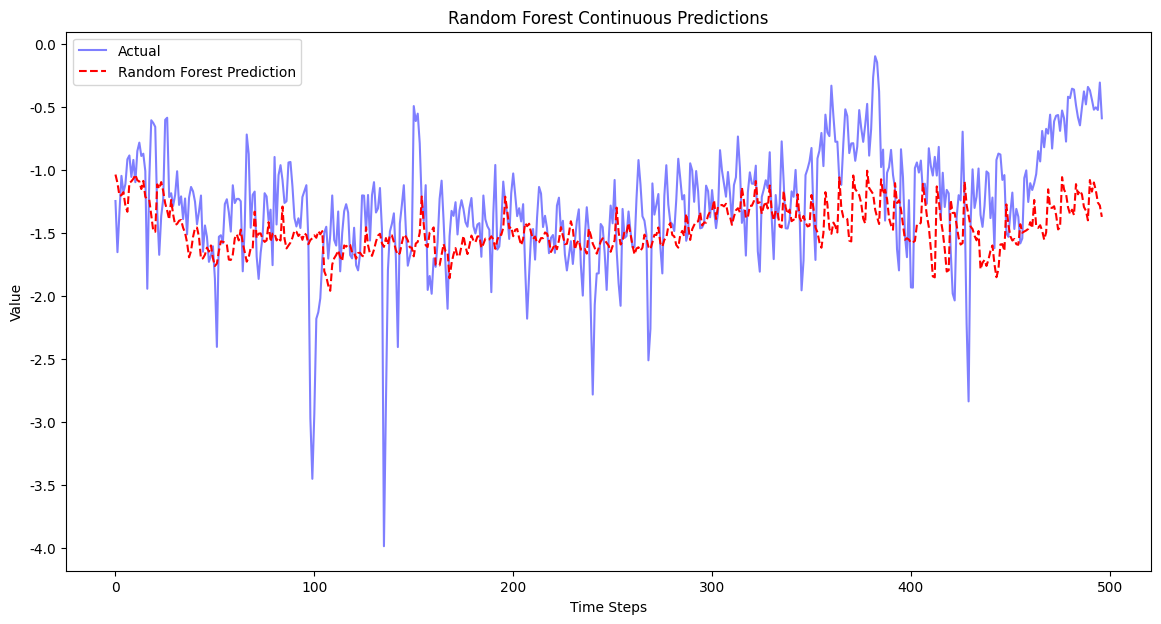

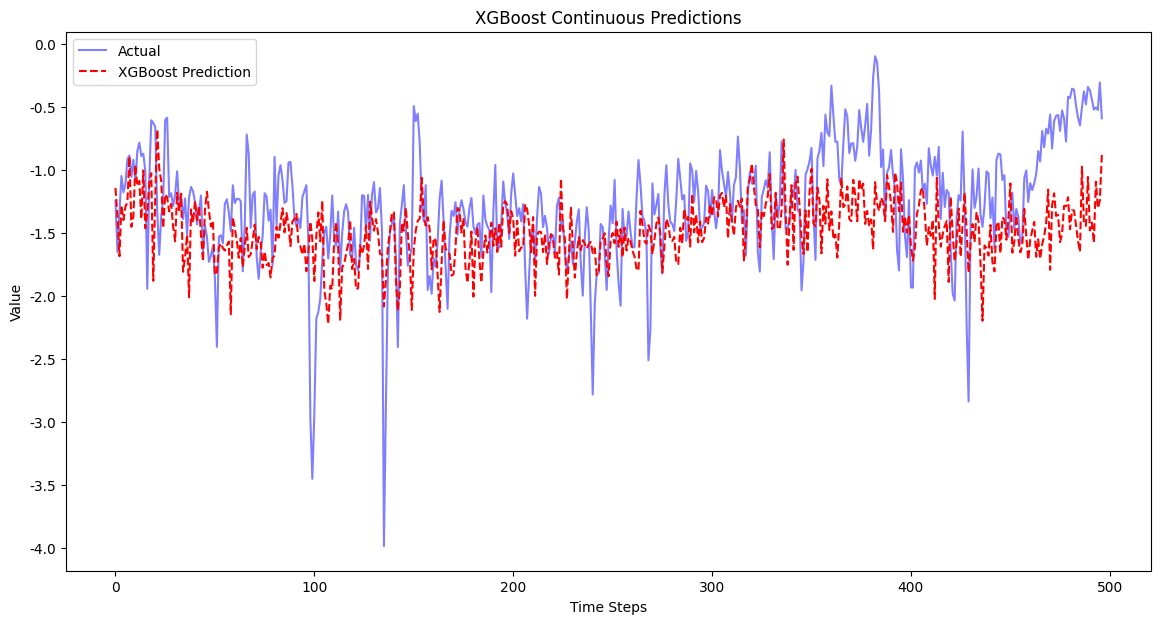

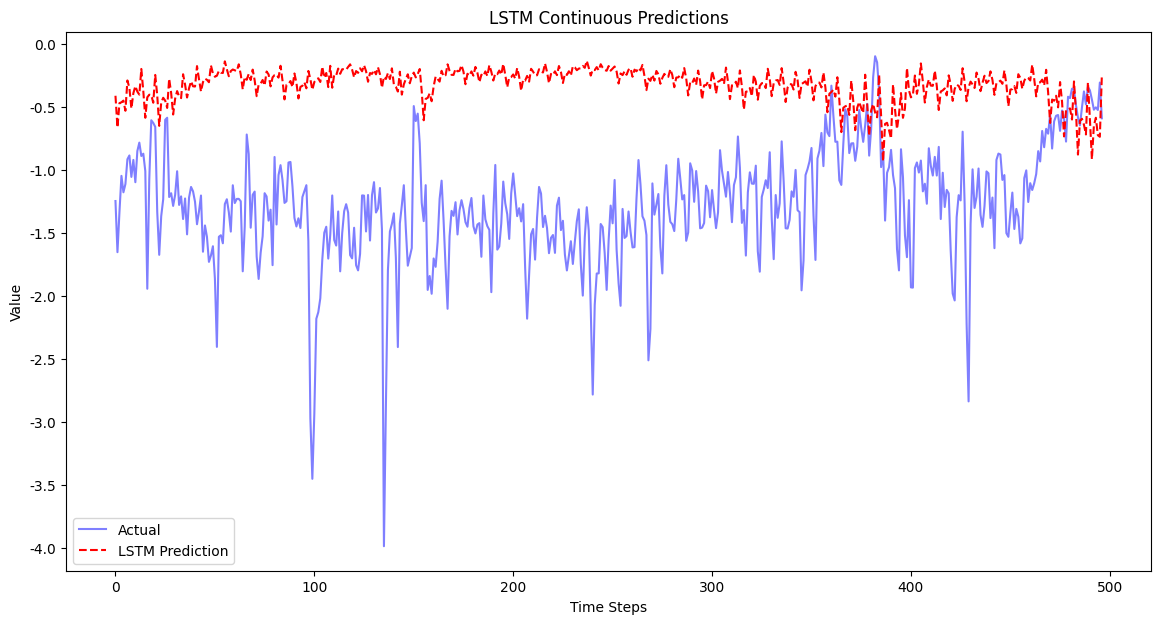

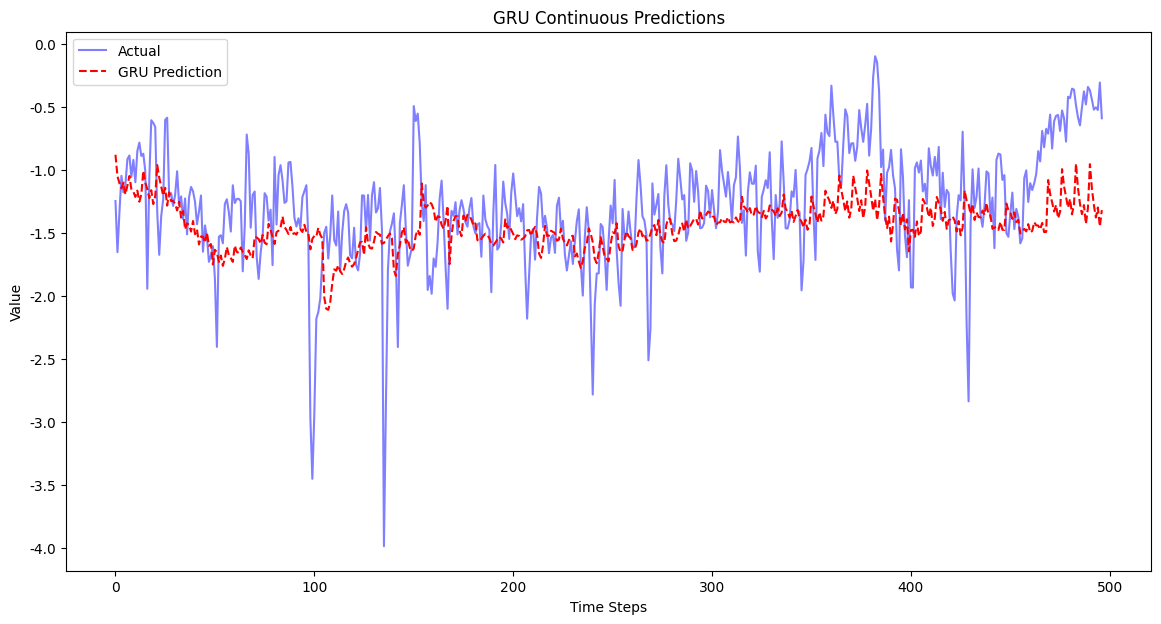

In [6]:
def plot_continuous_predictions(y_test, predictions, model_name, forecast_steps):
    continuous_predictions = np.concatenate(predictions[::forecast_steps])
    continuous_actual = np.concatenate(y_test[::forecast_steps])
    
    plt.figure(figsize=(14, 7))
    plt.plot(continuous_actual, color='blue', label='Actual', alpha=0.5)
    plt.plot(continuous_predictions, linestyle='dashed', color='red', label=f'{model_name} Prediction')
    plt.title(f'{model_name} Continuous Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

for model_name, predictions in models.items():
    plot_continuous_predictions(y_test, predictions, model_name, forecast_steps)